In [1]:
import torch
import xarray as xr
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
# Ruta al dataset en el bucket público de Google Cloud
dataset_path = 'gs://weatherbench2/datasets/era5/1959-2023_01_10-6h-240x121_equiangular_with_poles_conservative.zarr'

# Abrir el dataset
ds = xr.open_zarr(dataset_path, consolidated=True)

# Mostrar información del dataset
print(ds)

<xarray.Dataset> Size: 2TB
Dimensions:                                           (time: 93544,
                                                       longitude: 240,
                                                       latitude: 121, level: 13)
Coordinates:
  * latitude                                          (latitude) float64 968B ...
  * level                                             (level) int64 104B 50 ....
  * longitude                                         (longitude) float64 2kB ...
  * time                                              (time) datetime64[ns] 748kB ...
Data variables: (12/62)
    10m_u_component_of_wind                           (time, longitude, latitude) float32 11GB ...
    10m_v_component_of_wind                           (time, longitude, latitude) float32 11GB ...
    10m_wind_speed                                    (time, longitude, latitude) float32 11GB ...
    2m_dewpoint_temperature                           (time, longitude, latitude) float3

In [3]:
print("Variables disponibles en el dataset:")
for var_name in ds.data_vars:
    print(var_name)

Variables disponibles en el dataset:
10m_u_component_of_wind
10m_v_component_of_wind
10m_wind_speed
2m_dewpoint_temperature
2m_temperature
above_ground
ageostrophic_wind_speed
angle_of_sub_gridscale_orography
anisotropy_of_sub_gridscale_orography
boundary_layer_height
divergence
eddy_kinetic_energy
geopotential
geopotential_at_surface
geostrophic_wind_speed
high_vegetation_cover
integrated_vapor_transport
lake_cover
land_sea_mask
lapse_rate
leaf_area_index_high_vegetation
leaf_area_index_low_vegetation
low_vegetation_cover
mean_sea_level_pressure
mean_surface_latent_heat_flux
mean_surface_net_long_wave_radiation_flux
mean_surface_net_short_wave_radiation_flux
mean_surface_sensible_heat_flux
mean_top_downward_short_wave_radiation_flux
mean_top_net_long_wave_radiation_flux
mean_top_net_short_wave_radiation_flux
mean_vertically_integrated_moisture_divergence
potential_vorticity
relative_humidity
sea_ice_cover
sea_surface_temperature
slope_of_sub_gridscale_orography
snow_depth
soil_type
sp

In [24]:
region = ds.sel(latitude=slice(10, 30), longitude=slice(90, 120))

In [25]:
print("Latitudes seleccionadas:", region['latitude'].values)
print("Longitudes seleccionadas:", region['longitude'].values)
print("Tiempos seleccionados:", region['time'].values)

Latitudes seleccionadas: [10.5 12.  13.5 15.  16.5 18.  19.5 21.  22.5 24.  25.5 27.  28.5 30. ]
Longitudes seleccionadas: [ 90.   91.5  93.   94.5  96.   97.5  99.  100.5 102.  103.5 105.  106.5
 108.  109.5 111.  112.5 114.  115.5 117.  118.5 120. ]
Tiempos seleccionados: ['1959-01-01T00:00:00.000000000' '1959-01-01T06:00:00.000000000'
 '1959-01-01T12:00:00.000000000' ... '2023-01-10T06:00:00.000000000'
 '2023-01-10T12:00:00.000000000' '2023-01-10T18:00:00.000000000']


In [26]:
# División espacial
lat_split_train = int(region['latitude'].shape[0] * 0.7)
lat_split_val = int(region['latitude'].shape[0] * 0.85)
lon_split_train = int(region['longitude'].shape[0] * 0.7)
lon_split_val = int(region['longitude'].shape[0] * 0.85)

# División temporal
total_time = region['time'].shape[0]
time_split_train = int(total_time * 0.7)
time_split_val = int(total_time * 0.85)

# Datos de entrenamiento
train_data = region.isel(
    latitude=slice(0, lat_split_train),
    longitude=slice(0, lon_split_train),
    time=slice(0, time_split_train)
)

# Datos de validación
val_data = region.isel(
    latitude=slice(lat_split_train, lat_split_val),
    longitude=slice(lon_split_train, lon_split_val),
    time=slice(time_split_train, time_split_val)
)

# Datos de prueba
test_data = region.isel(
    latitude=slice(lat_split_val, None),
    longitude=slice(lon_split_val, None),
    time=slice(time_split_val, None)
)

# Imprimir tamaños de los conjuntos
print("Train shape:", train_data['u_component_of_wind'].shape)
print("Val shape:", val_data['u_component_of_wind'].shape)
print("Test shape:", test_data['u_component_of_wind'].shape)


Train shape: (65480, 13, 14, 9)
Val shape: (14032, 13, 3, 2)
Test shape: (14032, 13, 4, 3)


In [6]:
# Normalización por tiempo, latitud y longitud
u = (region['u_component_of_wind'].values - np.mean(region['u_component_of_wind'].values, axis=(0, 1, 2), keepdims=True)) / \
    np.std(region['u_component_of_wind'].values, axis=(0, 1, 2), keepdims=True)

v = (region['v_component_of_wind'].values - np.mean(region['v_component_of_wind'].values, axis=(0, 1, 2), keepdims=True)) / \
    np.std(region['v_component_of_wind'].values, axis=(0, 1, 2), keepdims=True)

p = (region['mean_sea_level_pressure'].values - np.mean(region['mean_sea_level_pressure'].values, axis=(0, 1, 2), keepdims=True)) / \
    np.std(region['mean_sea_level_pressure'].values, axis=(0, 1, 2), keepdims=True)

T = (region['temperature'].values - np.mean(region['temperature'].values, axis=(0, 1, 2), keepdims=True)) / \
    np.std(region['temperature'].values, axis=(0, 1, 2), keepdims=True)

q = (region['specific_humidity'].values - np.mean(region['specific_humidity'].values, axis=(0, 1, 2), keepdims=True)) / \
    np.std(region['specific_humidity'].values, axis=(0, 1, 2), keepdims=True)


In [7]:
print(u.shape, v.shape, p.shape, T.shape, q.shape)

(10, 13, 50, 50) (10, 13, 50, 50) (10, 50, 50) (10, 13, 50, 50) (10, 13, 50, 50)


In [8]:
print(f"u mean: {np.mean(u):.3f}, std: {np.std(u):.3f}")
print(f"v mean: {np.mean(v):.3f}, std: {np.std(v):.3f}")
print(f"p mean: {np.mean(p):.3f}, std: {np.std(p):.3f}")
print(f"T mean: {np.mean(T):.3f}, std: {np.std(T):.3f}")
print(f"q mean: {np.mean(q):.3f}, std: {np.std(q):.3f}")


u mean: -0.000, std: 1.000
v mean: 0.000, std: 1.000
p mean: -0.000, std: 1.000
T mean: -0.000, std: 1.000
q mean: -0.000, std: 1.000


In [9]:
u_tensor = torch.tensor(u, dtype=torch.float32, requires_grad=True)
v_tensor = torch.tensor(v, dtype=torch.float32, requires_grad=True)
p_tensor = torch.tensor(p, dtype=torch.float32, requires_grad=True)
T_tensor = torch.tensor(T, dtype=torch.float32, requires_grad=True)
q_tensor = torch.tensor(q, dtype=torch.float32, requires_grad=True)

In [10]:
latitudes = region['latitude'].values  # Coordenadas espaciales (latitud)
longitudes = region['longitude'].values  # Coordenadas espaciales (longitud)
times = region['time'].values  # Coordenadas temporales


In [11]:
x_coords, y_coords, t_coords = np.meshgrid(longitudes, latitudes, times, indexing='ij')

In [12]:
t_coords_numeric = (t_coords - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')  # Tiempo en segundos desde el 1 de enero de 1970

C:\Users\Antonina\AppData\Local\Temp\ipykernel_17892\177647037.py:1: UserWarning: no explicit representation of timezones available for np.datetime64
  t_coords_numeric = (t_coords - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')  # Tiempo en segundos desde el 1 de enero de 1970


In [13]:
x = np.stack([x_coords.flatten(), y_coords.flatten(), t_coords_numeric.flatten()], axis=1)


In [14]:
x = torch.tensor(x, dtype=torch.float32, requires_grad=True)

In [15]:
print(x.shape) 

torch.Size([25000, 3])


In [18]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, 128),  # Entradas: x, y, t
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 5)  # Salidas: u, v, p, T, q
        )

    def forward(self, x):
        return self.layers(x)


In [19]:
def loss_pde_extended(model, x, u, v, p, T, q):
    pred = model(x)
    u_pred, v_pred, p_pred, T_pred, q_pred = pred[:, 0], pred[:, 1], pred[:, 2], pred[:, 3], pred[:, 4]

    # Derivadas automáticas
    u_t = torch.autograd.grad(u_pred.sum(), x, create_graph=True)[0][:, 2]  # ∂u/∂t
    v_t = torch.autograd.grad(v_pred.sum(), x, create_graph=True)[0][:, 2]  # ∂v/∂t
    T_t = torch.autograd.grad(T_pred.sum(), x, create_graph=True)[0][:, 2]  # ∂T/∂t
    q_t = torch.autograd.grad(q_pred.sum(), x, create_graph=True)[0][:, 2]  # ∂q/∂t

    u_x = torch.autograd.grad(u_pred.sum(), x, create_graph=True)[0][:, 0]  # ∂u/∂x
    u_y = torch.autograd.grad(u_pred.sum(), x, create_graph=True)[0][:, 1]  # ∂u/∂y
    v_x = torch.autograd.grad(v_pred.sum(), x, create_graph=True)[0][:, 0]  # ∂v/∂x
    v_y = torch.autograd.grad(v_pred.sum(), x, create_graph=True)[0][:, 1]  # ∂v/∂y
    T_x = torch.autograd.grad(T_pred.sum(), x, create_graph=True)[0][:, 0]  # ∂T/∂x
    T_y = torch.autograd.grad(T_pred.sum(), x, create_graph=True)[0][:, 1]  # ∂T/∂y
    q_x = torch.autograd.grad(q_pred.sum(), x, create_graph=True)[0][:, 0]  # ∂q/∂x
    q_y = torch.autograd.grad(q_pred.sum(), x, create_graph=True)[0][:, 1]  # ∂q/∂y
    p_x = torch.autograd.grad(p_pred.sum(), x, create_graph=True)[0][:, 0]  # ∂p/∂x
    p_y = torch.autograd.grad(p_pred.sum(), x, create_graph=True)[0][:, 1]  # ∂p/∂y

    # Residuales de las PDEs
    momentum_u = u_t + u_pred * u_x + v_pred * u_y + p_x
    momentum_v = v_t + u_pred * v_x + v_pred * v_y + p_y
    continuity = u_x + v_y
    energy = T_t + u_pred * T_x + v_pred * T_y
    moisture = q_t + u_pred * q_x + v_pred * q_y

    # **Diagnóstico: Imprimir valores promedio de los residuales**
    if torch.isnan(momentum_u.mean()) or torch.isnan(momentum_v.mean()):
        print("WARNING: Residuals contain NaN values!")
    # print(f"Momentum_u mean: {momentum_u.mean().item()}, Momentum_v mean: {momentum_v.mean().item()}")
    # print(f"Continuity mean: {continuity.mean().item()}")
    # print(f"Energy mean: {energy.mean().item()}, Moisture mean: {moisture.mean().item()}")

    # Pérdida total
    loss_physics = torch.mean(momentum_u**2 + momentum_v**2 + continuity**2 + energy**2 + moisture**2)
    loss_regularization = torch.mean(u_pred**2 + v_pred**2 + p_pred**2 + T_pred**2 + q_pred**2)
    loss_total = loss_physics + 1e-4 * loss_regularization
    return loss_total


In [20]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)



In [21]:
model = PINN()
model.apply(init_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# Convertir p a tensor y expandir
p_tensor = torch.tensor(p, dtype=torch.float32, requires_grad=True)
p_expanded = p_tensor.unsqueeze(1).repeat(1, T.shape[1], 1, 1)  # Repite para igualar el número de niveles

loss_history = []

# Entrenamiento
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = loss_pde_extended(model, x, u_tensor, v_tensor, p_expanded, T_tensor, q_tensor)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")


Epoch 0, Loss: 0.00019946193788200617
Epoch 100, Loss: 4.097922445822633e-09
Epoch 200, Loss: 1.0429394029171438e-13
Epoch 300, Loss: 1.5922925036158323e-16
Epoch 400, Loss: 7.138095539022249e-17
Epoch 500, Loss: 9.924761805339482e-17
Epoch 600, Loss: 7.797470322045829e-17
Epoch 700, Loss: 3.2128958923535576e-17
Epoch 800, Loss: 6.573925687626888e-18
Epoch 900, Loss: 3.667946145292454e-17


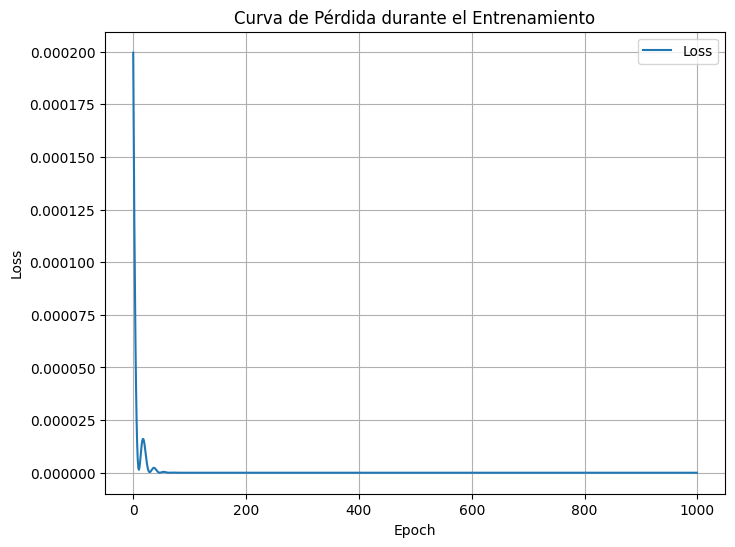

In [23]:
plt.figure(figsize=(8, 6))
plt.plot(range(epochs), loss_history, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Curva de Pérdida durante el Entrenamiento")
plt.legend()
plt.grid()
plt.show()